### Imports

In [12]:
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt

In [13]:
from sklearn.preprocessing import LabelEncoder

### Read Files

In [14]:
X_fileName = []
y_val = []

In [15]:
import os
l = ["C","down","fist_moved","five","four","hang","heavy","index","L","ok","palm","palmm","palmu","three","two","up"]
for str in l:
    for filename in os.listdir("train/"+str):
        X_fileName.append("train/"+str+"/"+filename)
        y_val.append(str)

# for fileName in sorted(glob.iglob('train/**/**')):
#     X_fileName.append(fileName)
#     y_val.append(fileName.split("\\")[-2])

##### Converting to DataFrame for easy handling

In [16]:
myDf = pd.DataFrame()
myDf['fileName'] = X_fileName
myDf['label'] = y_val

In [17]:
myLabelEncoder = LabelEncoder()
myDf['label_val'] = myLabelEncoder.fit_transform(myDf['label'])

### PreProcessing

In [18]:
def preprocessingSingleImage(filepath):
    
    img = cv2.imread(filepath)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    k = cv2.normalize(img1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    blur = cv2.GaussianBlur(k,(5,5),0)
    ret, thresh1 = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    
    for k in range(2, nb_components):
        if sizes[k] > max_size:
            max_label = k
            max_size = sizes[k]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255

    new_image = img2[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
    image_for_input = cv2.resize(new_image, (100, 100), interpolation = cv2.INTER_NEAREST)
    
    return image_for_input

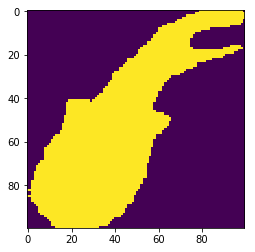

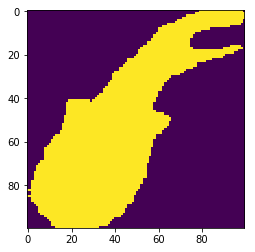

In [20]:
plt.imshow(preprocessingSingleImage(myDf['fileName'][0]))

### Creating our generator

In [21]:
def my_generator(features, batch_size=16):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 100, 100, 1))
    batch_labels = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features[i] = preprocessingSingleImage(features.loc[index[0]]['fileName']).reshape([100, 100, 1])
            batch_labels[i] = features.loc[index[0]]['label_val']
        yield batch_features, batch_labels

### Model Benchmarking

##### Nvidia Model

In [22]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D

import tensorflow as tf

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)


# create model
model = Sequential()
#add model layers

model.add(Conv2D(100, kernel_size=3, activation="relu", input_shape=(100,100,1)))
model.add(Conv2D(100, kernel_size=3, activation="relu"))
model.add(Conv2D(100, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(16, activation="softmax"))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# from keras.utils import to_categorical
# y_binary = to_categorical(np.array(Y))
# y_binary_test = to_categorical(np.array(Y_test))

# print((np.expand_dims(np.array(X), axis=-1))

# # Fit the model
model.fit_generator(my_generator(myDf), samples_per_epoch=200, nb_epoch=5)


# # evaluate the model
# scores = model.evaluate(np.expand_dims(np.array(X_test), axis=-1), y_binary_test)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=5, steps_per_epoch=200)`
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of b

Epoch 1/5
Epoch 1/5
 27/200 [===>..........................] - ETA: 7:13 - loss: 13.1182 - acc: 0.1782